In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "../Dataset/selected_plants",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "../Dataset/selected_plants",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

class_names = train_ds.class_names
print("Classes:", class_names)
print("Number of classes:", len(class_names))


Found 3912 files belonging to 10 classes.
Using 3130 files for training.
Found 3912 files belonging to 10 classes.
Using 782 files for validation.
Classes: ['Anthurium (Anthurium andraeanum)', 'Calathea', 'Chinese evergreen (Aglaonema)', 'Dumb Cane (Dieffenbachia spp.)', 'Elephant Ear (Alocasia spp.)', 'Iron Cross begonia (Begonia masoniana)', 'Monstera Deliciosa (Monstera deliciosa)', 'Peace lily', 'Polka Dot Plant (Hypoestes phyllostachya)', 'Pothos (Ivy arum)']
Number of classes: 10


In [12]:
import json

with open("../models/class_names.json", "w") as f:
    json.dump(class_names, f, indent=2)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(
    lambda x, y: (normalization_layer(x), y),
    num_parallel_calls=AUTOTUNE
).apply(tf.data.experimental.ignore_errors())

val_ds = val_ds.map(
    lambda x, y: (normalization_layer(x), y),
    num_parallel_calls=AUTOTUNE
).apply(tf.data.experimental.ignore_errors())

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [7]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # transfer learning

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2423242 (9.24 MB)
Trainable params: 16

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10


90/90 [==============================] - 110s 1s/step - loss: 1.2361 - accuracy: 0.5712 - val_loss: 0.8716 - val_accuracy: 0.6834
Epoch 2/10
90/90 [==============================] - 102s 1s/step - loss: 0.7557 - accuracy: 0.7488 - val_loss: 0.6971 - val_accuracy: 0.7727
Epoch 3/10
90/90 [==============================] - 106s 1s/step - loss: 0.6194 - accuracy: 0.7946 - val_loss: 0.8066 - val_accuracy: 0.7127
Epoch 4/10
90/90 [==============================] - 100s 1s/step - loss: 0.5282 - accuracy: 0.8242 - val_loss: 0.5826 - val_accuracy: 0.8047
Epoch 5/10
90/90 [==============================] - 100s 1s/step - loss: 0.4723 - accuracy: 0.8398 - val_loss: 0.6264 - val_accuracy: 0.7713
Epoch 6/10
90/90 [==============================] - 101s 1s/step - loss: 0.4922 - accuracy: 0.8308 - val_loss: 0.6207 - val_accuracy: 0.7755
Epoch 7/10
90/90 [==============================] - 100s 1s/step - loss: 0.4153 - accuracy: 0.8704 - val_loss: 0.5679 - val_accuracy: 0.8020
Epoch 8/10


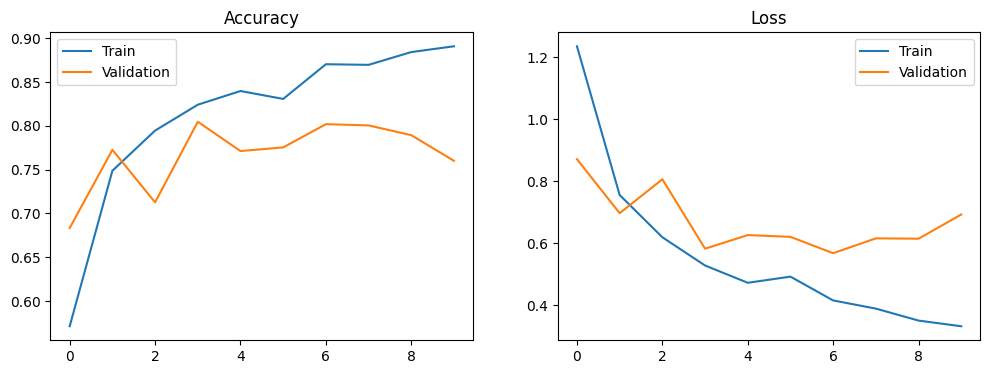

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()


In [10]:
model.save("../models/leaf_scan_model.h5")
print("Model saved successfully")


c:\Users\tenn2\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully
